# 1. Instalacja oraz konfiguracja podstawowych paczek

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.3.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
bi

In [4]:
import tensorflow as tf
import os

In [6]:
# Poniższy kod zapobiega  przydzielaniu przez tensorflow całości pamięci GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Weryfikacja, kontrola oraz usunięcie z badania uszkodzonych, wadliwych zdjęć

In [105]:
import cv2
import imghdr

In [106]:
data_dir = 'data'

In [107]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [108]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path) #sprawdzam czy mogę załadować zdjęcie do biblioteki opencv
            tip = imghdr.what(image_path) #sprwadzam czy rozsrzeszenie zdjęcia pokrywa się z akceptowalnymi rozszerzeniami
            if tip not in image_exts:
                print('Zdjęcie posiada nieobsługiwane rozszerzenie {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Wystąpił problem ze zdjęciem {}'.format(image_path))

# 3. Ładowanie danych

In [109]:
import numpy as np
from matplotlib import pyplot as plt

In [110]:
data = tf.keras.utils.image_dataset_from_directory('data') #wywołanie zwróci zestaw danych z wskazanego katalogu, ujednolici, zmniejszy zdjęcia

Found 200 files belonging to 2 classes.


In [111]:
data_iterator = data.as_numpy_iterator() #konwersja elementów zestawów danych na iterator, pozwoli nam uzyskać dostęp do poszczególnych danych

In [112]:
batch = data_iterator.next() #dostęp do zestawu danych, pobranie pierwszej iteracji

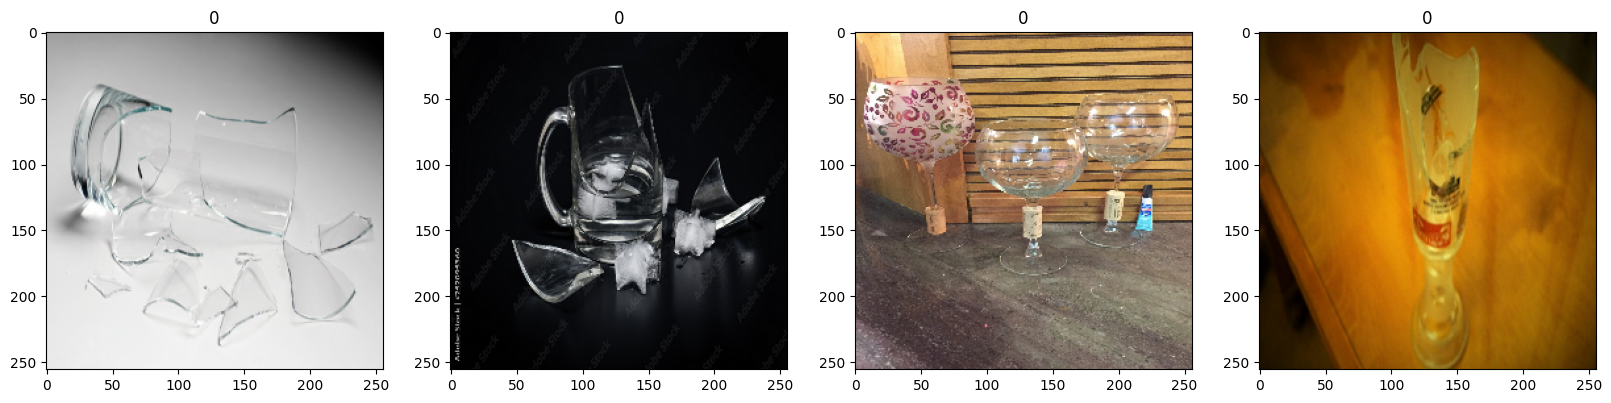

In [113]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Wstępne przetwarzanie danych

In [114]:
# przeskalowanie danych, w celu optymalizacji
data = data.map(lambda x,y: (x/255, y)) # funkcja .map umożliwia operacje na całym zestawie danych
data.as_numpy_iterator().next()

(array([[[[0.01176471, 0.01176471, 0.01960784],
          [0.01176471, 0.01176471, 0.01960784],
          [0.01176471, 0.01176471, 0.01960784],
          ...,
          [0.01176471, 0.01176471, 0.01176471],
          [0.01176471, 0.01176471, 0.01176471],
          [0.01176471, 0.01176471, 0.01176471]],
 
         [[0.01176471, 0.01176471, 0.01960784],
          [0.01176471, 0.01176471, 0.01960784],
          [0.01176471, 0.01176471, 0.01960784],
          ...,
          [0.01176471, 0.01176471, 0.01176471],
          [0.01176471, 0.01176471, 0.01176471],
          [0.01176471, 0.01176471, 0.01176471]],
 
         [[0.01176471, 0.01176471, 0.01960784],
          [0.01176471, 0.01176471, 0.01960784],
          [0.01176471, 0.01176471, 0.01960784],
          ...,
          [0.01176471, 0.01176471, 0.01176471],
          [0.01176471, 0.01176471, 0.01176471],
          [0.01176471, 0.01176471, 0.01176471]],
 
         ...,
 
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607

In [115]:
train_size = int(len(data)*.7) # część zestawu danych, która będzie odpowiedzalna za trenowanie modelu
val_size = int(len(data)*.2)+1 # część zestwu danych odpowiedzialna za walidacje
test_size = int(len(data)*.1)+1 # część zestawu danych odpowiedzialna za końcowe testy

In [116]:
train_size

4

In [117]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 5. Budowa modelu głębokiego uczenia

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [119]:
model = Sequential()

In [120]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [121]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [122]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

# 6. Trenowanie

In [123]:
logdir='logs'

In [124]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [125]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 1s 140ms/step - loss: 1.5463 - accuracy: 0.6172 - val_loss: 1.9521 - val_accuracy: 0.4844
Epoch 2/20
4/4 [==============================] - 1s 128ms/step - loss: 1.2500 - accuracy: 0.4609 - val_loss: 0.6384 - val_accuracy: 0.6875
Epoch 3/20
4/4 [==============================] - 1s 122ms/step - loss: 0.6319 - accuracy: 0.6172 - val_loss: 0.5972 - val_accuracy: 0.7031
Epoch 4/20
4/4 [==============================] - 1s 126ms/step - loss: 0.5742 - accuracy: 0.6875 - val_loss: 0.5303 - val_accuracy: 0.7031
Epoch 5/20
4/4 [==============================] - 1s 121ms/step - loss: 0.4677 - accuracy: 0.7812 - val_loss: 0.5227 - val_accuracy: 0.7500
Epoch 6/20
4/4 [==============================] - 1s 128ms/step - loss: 0.4000 - accuracy: 0.8359 - val_loss: 0.3961 - val_accuracy: 0.8438
Epoch 7/20
4/4 [==============================] - 1s 123ms/step - loss: 0.4336 - accuracy: 0.8047 - val_loss: 0.3573 - val_accuracy: 0.8438
Epoch 8/20
4/4 [====

# 7. Badanie wydajności, wykaz strat

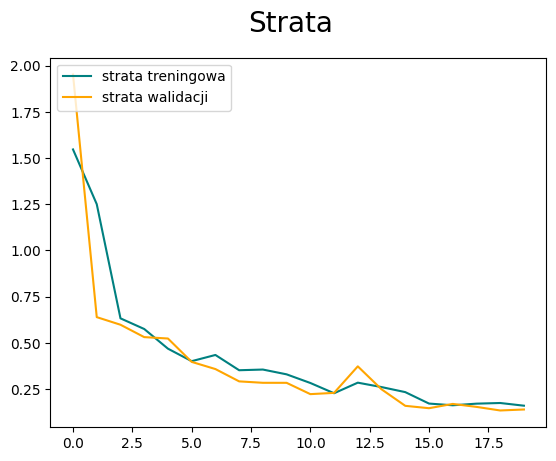

In [126]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='strata treningowa')
plt.plot(hist.history['val_loss'], color='orange', label='strata walidacji')
fig.suptitle('Strata', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 8. Badanie wydajności, wykaz dokładności

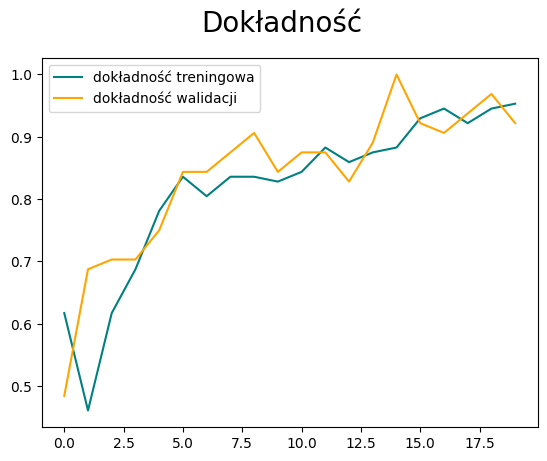

In [142]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='dokładność treningowa')
plt.plot(hist.history['val_accuracy'], color='orange', label='dokładność walidacji')
fig.suptitle('Dokładność', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Ocena wydajności modelu

In [143]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [144]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [145]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# 10. Test

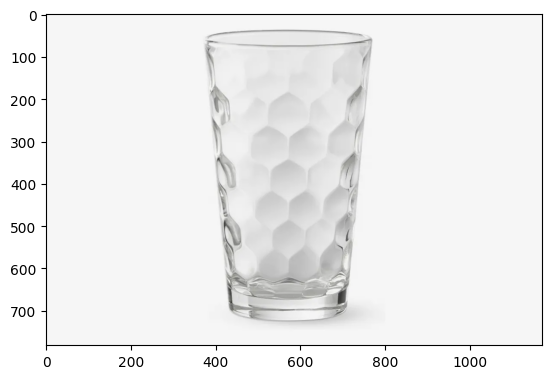

In [154]:
img = cv2.imread('success.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

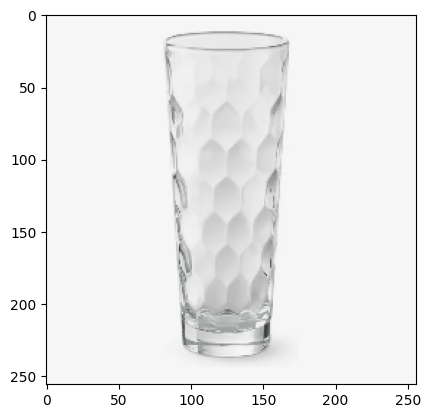

In [155]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [156]:
yhat  = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 11ms/step


In [157]:
yhat

array([[0.89710325]], dtype=float32)

In [158]:
if yhat > 0.5:
    print(f'Wskazany obraz został sklasyfikowany jako część prawidłowa')
else:
    print(f'Wskazany obraz został sklasyfikowany jako część uszkodzona')

Wskazany obraz został sklasyfikowany jako część prawidłowa


# 9. Zapis modelu

In [137]:
from tensorflow.keras.models import load_model

In [138]:
model.save(os.path.join('models', 'imageclassicationversionlive.h5'))

In [139]:
new_model = load_model(os.path.join('models', 'imageclassicationversionlive.h5'))

In [140]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 34ms/step


In [141]:
if yhat > 0.5:
    print(f'Wskazany obraz został sklasyfikowany jako część prawidłowa')
else:
    print(f'Wskazany obraz został sklasyfikowany jako część uszkodzona')

Wskazany obraz został sklasyfikowany jako część prawidłowa
